In [14]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [15]:
words = open("./datasets/names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [16]:
# Build vocabulary of characters and mapping to/form integers

chars = sorted(list(set("".join(words))))
stoi = {s : i for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{0: '.', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [53]:
# Build the dataset

block_size = 3 # Context Length: how many characters do we take to predict next word
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), "----->", itos[ix])
        context = context[1:] + [ix] # crop first index and append new one
X = torch.tensor(X)
Y = torch.tensor(Y)

In [54]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [55]:
# Build the dataset
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), "---->", itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
# creating train, dev and test data
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev= build_dataset(words[n1:n2])
Xte, Yte= build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [56]:
# Explore more on Tensor representation in pytorch and their indexes manipulation
# Need to understand how tenson works
# How kernels and mathematical calculation works
C = torch.randn((27, 2))

In [57]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [58]:
w1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [59]:
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)

In [60]:
h

tensor([[ 0.5498, -0.9541,  0.3189,  ..., -0.9029,  0.8811,  0.5963],
        [-0.2661, -0.9963,  0.9399,  ..., -0.9288,  0.9990, -0.5919],
        [ 0.9859, -0.9990, -0.4160,  ..., -0.9989,  1.0000, -0.9942],
        ...,
        [-0.9994,  0.8334, -0.7353,  ..., -0.7584,  1.0000, -1.0000],
        [ 0.9996, -0.9839, -0.2402,  ..., -1.0000,  0.8026,  0.9992],
        [ 0.9961, -0.9941,  0.9630,  ..., -0.5555, -0.6130, -0.9669]])

In [61]:
h.shape

torch.Size([228146, 100])

In [62]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [63]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [64]:
for p in parameters:
    p.requires_grad = True

In [66]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 **lre

In [67]:
lri = []
lossi = []
stepi = []

In [77]:
for i in range(200000):
    # minibatch
    # This is for not to do forward and backward pass at once
    # instead of do things in batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # udpate
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

#print(loss.item())


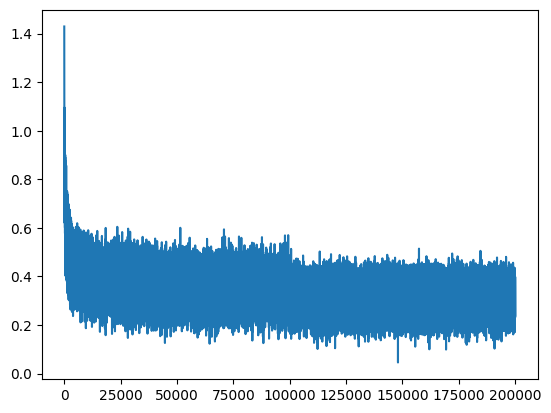

In [70]:
plt.plot(stepi, lossi)

In [78]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)                                            
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0303, grad_fn=<NllLossBackward0>)

In [79]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0816, grad_fn=<NllLossBackward0>)

KeyError: 26

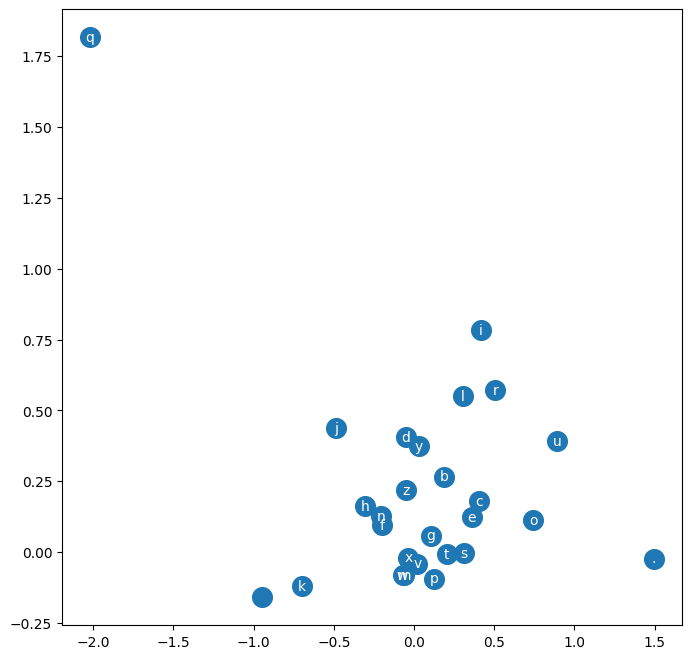

In [74]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [75]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [82]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

nus.
kh.
z.
kinzlin.
eisi.
m.
rienst.
coe.
mel.
.
ri.
len.
miri.
ndroee.
.
li.
t.
rose.
s.
leu.
